# Minimum Example data

Goals:
  - Understand the various data format used in DOSED
  - Manipulate H5 format
  
Content:
 1. How to download and manipulate the data of the Minimum Example.
 2. How to convert the downloaded data from the Minimum Example to the unique H5 format used in DOSED.

# 1. Download

run `python minimum_example/download_data.py ./data/downloads/` to download base data in "./data/downloads"

You will download in `data/downloads/minimum_example`:
 - 21 EDF files (standard format used in medical EEG see https://www.edfplus.info/)
 - 21 JSON files containing spindle annotations in JSON for each record. Annotation start and end are in seconds from the beginning of the record
 
## Below is a short example on how to read EDF and how the annotations look

In [2]:
import pyedflib
import json

record = "0e20159f-cd04-4ce8-afaf-687dd450ba73"

annotations = json.load(open("../data/downloads/{}_spindle.json".format(record)))
with pyedflib.EdfReader("../data/downloads/{}.edf".format(record)) as edf_file:
    labels = edf_file.getSignalLabels()
    frequencies = edf_file.getSampleFrequencies()
    data = {label: edf_file.readSignal(i) for i, label in enumerate(labels)}

print("Channels information:")
for label, frequency in zip(labels, frequencies):
    print("  ", label, "frequency:", frequency, "Hz")
    
print("\nNumber of spindles annotated:", len(annotations))


Channels information:
   eeg_0 frequency: 64 Hz
   eeg_1 frequency: 64 Hz

Number of spindles annotated: 1097


## We check the signal around the first spindle: 

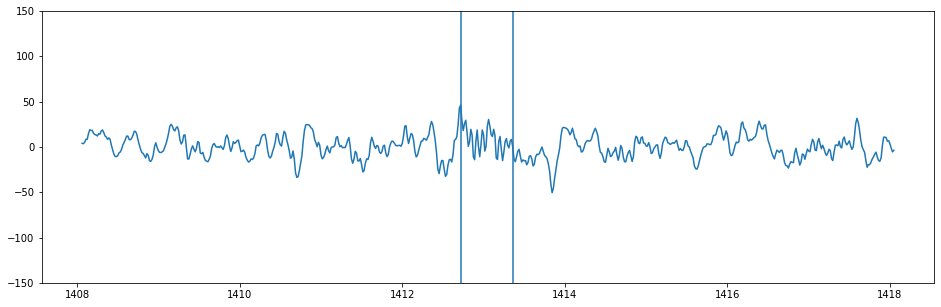

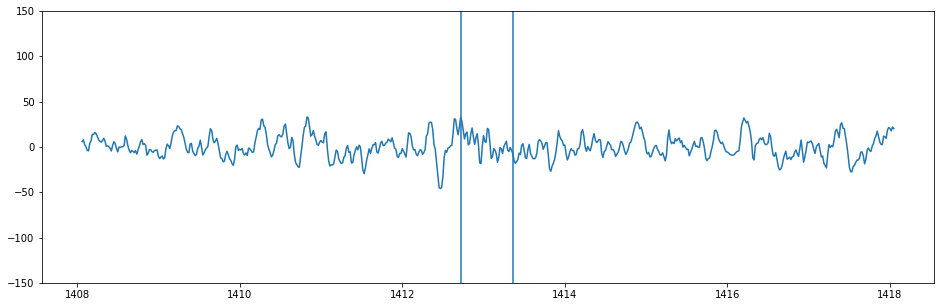

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

index_spindle = 13
window_duration = 5

# retrieve spindle at the right index
spindle_start = float(annotations[index_spindle]["start"])
spindle_end = float(annotations[index_spindle]["end"])

# center data window on annotated spindle 
start_window = spindle_start + (spindle_end - spindle_start) / 2 - window_duration
stop_window = spindle_start + (spindle_end - spindle_start) / 2 + window_duration

for label, frequency in zip(labels, frequencies):
    # Retrieve EEG data at right index
    index_start = int(start_window * frequency)
    index_stop = int(stop_window * frequency)
    y = data[label][index_start:index_stop]
    
    # Build corresponding time support
    t = start_window + np.cumsum(np.ones(index_stop - index_start) * 1 / frequency)

    plt.figure(figsize=(16, 5))
    plt.plot(t, y)
    plt.axvline(spindle_end)
    plt.axvline(spindle_start)
    plt.ylim([-150, 150])
    plt.show()

# 2. To H5

Run `python minimum_example/to_h5.py ./data/downloads/ ./data/h5/` to convert edf and annotation in h5 files in the "./data/h5" directory
 
HDF5 is a hierarchical data format, easy to manipulate in python with h5py (https://www.h5py.org/).

The idea is to create a copy from an original database with a *specific format* (EDF, BDF, CSV, HDF5, JSON) to a unique *H5 format* so that furter processing processings will use unified scripts. 

## Below is a short example on how to work with an H5 file on the same sample

This is not important to train DOSED since every further manipulation will use scripts. That means you won't need to manipulate the H5 files

In [5]:
import h5py

h5 = h5py.File("../data/h5/{}.h5".format(record))

print("Content of the h5 file: ")
for k, v in h5.items():
    print("  ", k, "-->", v)
    
print("\n Sampling frequency can be found in h5 attributes:")
for channel in ["eeg_0", "eeg_1"]:
    print("  ", channel, "-->", h5[channel].attrs["fs"], "Hz")

print("\nSpindle is another group containing start and duration from the start of the record in seconds:")
for k, v in h5["spindle"].items():
    print("  ", k, "-->", v)

Content of the h5 file: 
   eeg_0 --> <HDF5 dataset "eeg_0": shape (1382400,), type "<f8">
   eeg_1 --> <HDF5 dataset "eeg_1": shape (1382400,), type "<f8">
   spindle --> <HDF5 group "/spindle" (2 members)>

 Sampling frequency can be found in h5 attributes:
   eeg_0 --> 64 Hz
   eeg_1 --> 64 Hz

Spindle is another group containing start and duration from the start of the record in seconds:
   duration --> <HDF5 dataset "duration": shape (1097,), type "<f8">
   start --> <HDF5 dataset "start": shape (1097,), type "<f8">


The EDF contains the two original eeg channels together with the original spindle annotation.

## Below is the same visualization as with the EDF

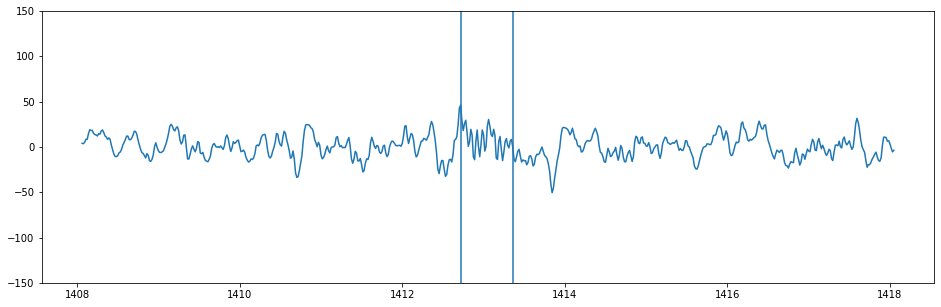

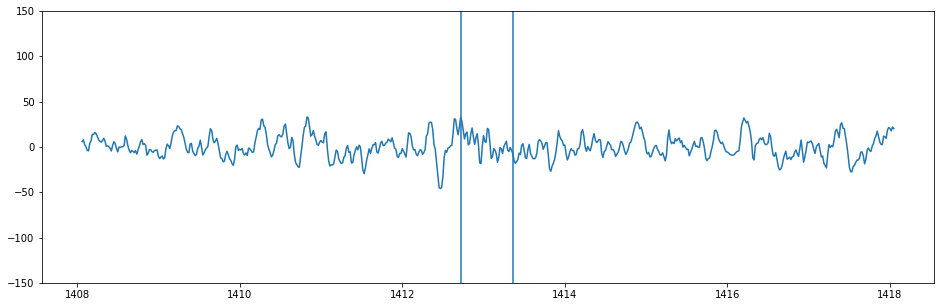

In [6]:
spindle_start = h5["spindle/start"][index_spindle]
spindle_duration = h5["spindle/duration"][index_spindle]

for channel in ["eeg_0", "eeg_1"]:
    frequency =  h5[channel].attrs["fs"]

    # Retrieve EEG data at right index
    index_start = int(start_window * frequency)
    index_stop = int(stop_window * frequency)
    y = h5[channel][index_start:index_stop]
    
    # Build corresponding time support
    t = start_window + np.cumsum(np.ones(index_stop - index_start) * 1 / frequency)

    plt.figure(figsize=(16, 5))
    plt.plot(t, y)
    plt.axvline(spindle_end)
    plt.axvline(spindle_start)
    plt.ylim([-150, 150])
    plt.show()
    
h5.close()